## imports, helper functions

In [2]:
import torch
from qadence import feature_map, hea, chain, add
from qadence import QNN, QuantumCircuit, Z
from qadence.types import BasisSet, ReuploadScaling
import matplotlib.pyplot as plt


In [3]:
def dfdx_equation(x: torch.Tensor) -> torch.Tensor:
    """Derivative as per the equation."""
    return (4*x**3 + x**2 - 2*x - 0.5)

In [4]:
def calc_deriv(outputs: torch.Tensor, inputs: torch.Tensor) -> torch.Tensor:
    """Compute a derivative of model that learns f(x), computes df/dx using torch.autograd."""
    grad = torch.autograd.grad(
        outputs=outputs,
        inputs=inputs,
        grad_outputs = torch.ones_like(inputs),
        create_graph = True,
        retain_graph = True,
    )[0]
    return grad

## define loss function

In [5]:
criterion = torch.nn.MSELoss()

def loss_fn(model: torch.nn.Module, inputs: torch.Tensor) -> torch.Tensor:
    """Loss function encoding the problem to solve."""
    # Equation loss
    model_output = model(inputs)
    deriv_model = calc_deriv(model_output, inputs)
    deriv_exact = dfdx_equation(inputs)
    ode_loss = criterion(deriv_model, deriv_exact)

    # Boundary loss, f(0) = 10
    boundary_model = model(torch.tensor([[0.0]]))
    boundary_exact = torch.tensor([[10.0]])
    boundary_loss = criterion(boundary_model, boundary_exact)

    return ode_loss + boundary_loss

## define feature map, variational ansatz, model

In [6]:
n_qubits = 3
depth = 4

# Feature map
fm = feature_map(
    n_qubits = n_qubits,
    param = "x",
    fm_type = BasisSet.CHEBYSHEV,
    reupload_scaling = ReuploadScaling.CONSTANT,
)

# Ansatz
ansatz = hea(n_qubits = n_qubits+1, depth = depth)

# Observable
observable = 7*(Z(0) + Z(1) + Z(2)) + 15*Z(3)

circuit = QuantumCircuit(n_qubits+1, chain(fm, ansatz))
model = QNN(circuit = circuit, observable = observable, inputs = ["x"])

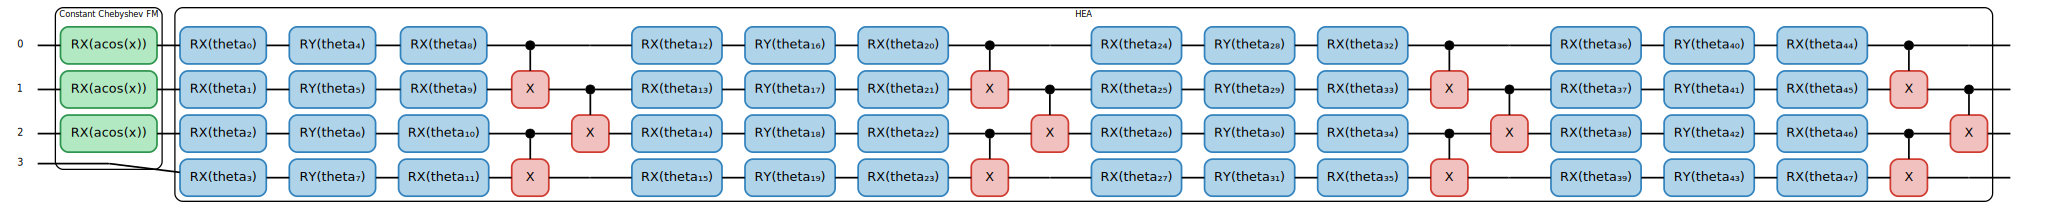

In [7]:
from qadence.draw import display

display(circuit)

## train model

In [8]:
n_epochs = 600
n_points = 20

xmin = -0.99
xmax = 0.99

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

for epoch in range(n_epochs):
    optimizer.zero_grad()

    # Training data. We unsqueeze essentially making each batch have a single x value.
    x_train = (xmin + (xmax-xmin)*torch.rand(n_points, requires_grad = True)).unsqueeze(1)

    loss = loss_fn(inputs = x_train, model = model)
    loss.backward()
    optimizer.step()

## plot result

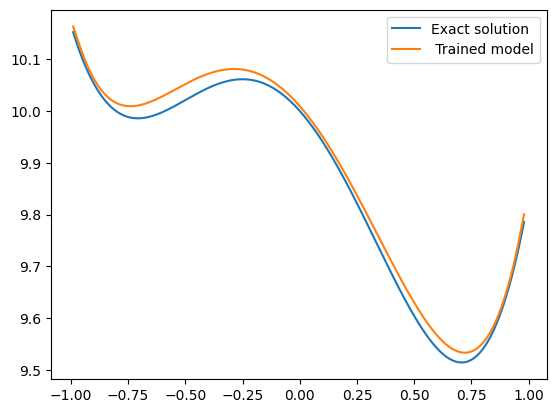

In [9]:
import matplotlib.pyplot as plt

def f_exact(x: torch.Tensor) -> torch.Tensor:
    return (x**4 + (1/3)*x**3 - x**2 - 0.5*x + 10)

x_test = torch.arange(xmin, xmax, step = 0.01).unsqueeze(1)

result_exact = f_exact(x_test).flatten()

result_model = model(x_test).flatten().detach()

plt.plot(x_test, result_exact, label = "Exact solution")
plt.plot(x_test, result_model, label = " Trained model")
#plt.ylim(ymin=0, ymax=12)
plt.savefig('odesol.png')
plt.legend()